In [85]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
import utils.metrics

from skimage.transform import rescale, resize
from skimage.color import rgb2gray,rgb2lab

In [86]:
config_vars = {}

## Set path variables

Here you need to change the pathway to where your images lie. The image name of the cellprofiler image, is expected to be the same as the name of the ground truth annotation. 

You will have 3 folders for this:

    1. One folder for the ground truth annotations
    2. One folder where you store the cellprofiler predictions
    3. One folder where the label images, created from the cellprofiler prediction, will be stored 
    
The cellprofiler image is expected to be of the same size as the ground truth annotation (1104x1104)

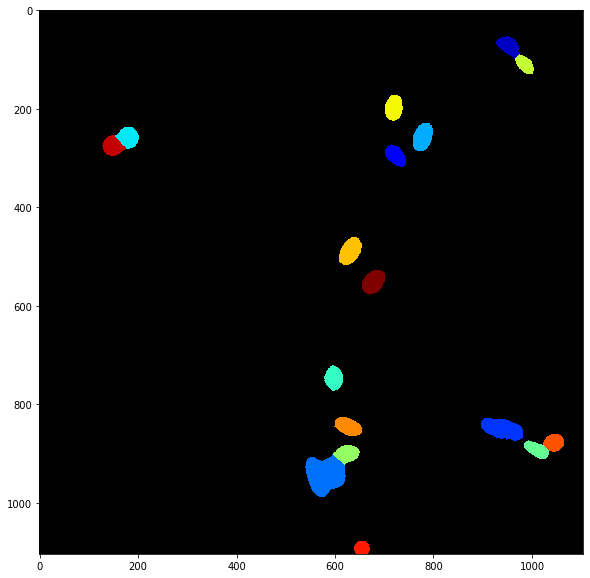

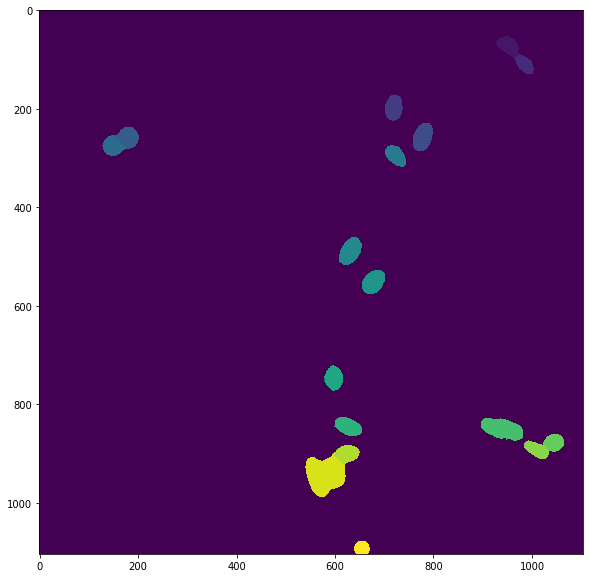

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702090001_G03f02d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.


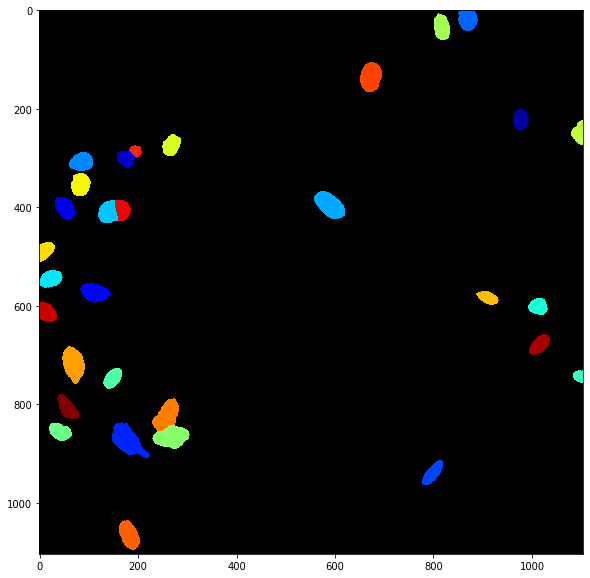

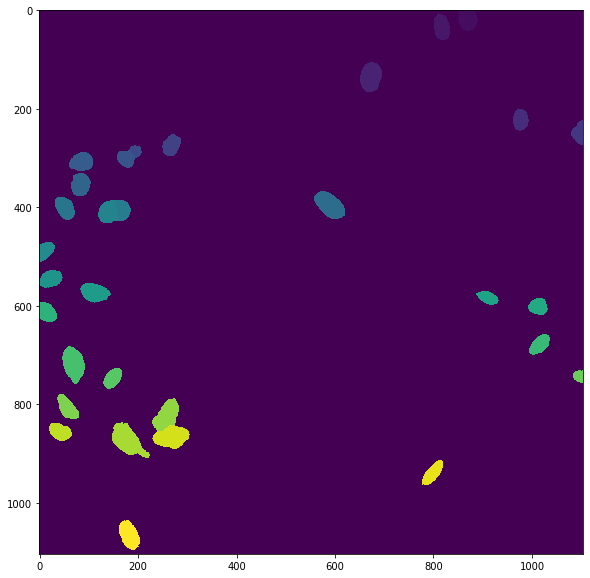

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170802000001_I10f05d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 31]. Convert image to uint8 prior to saving to suppress this warning.


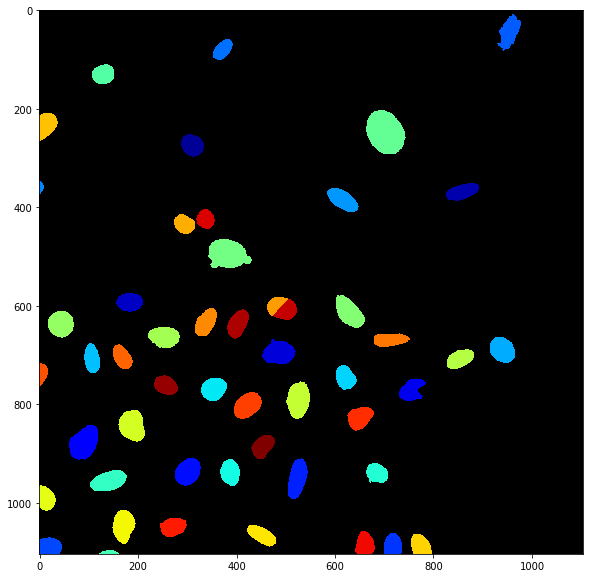

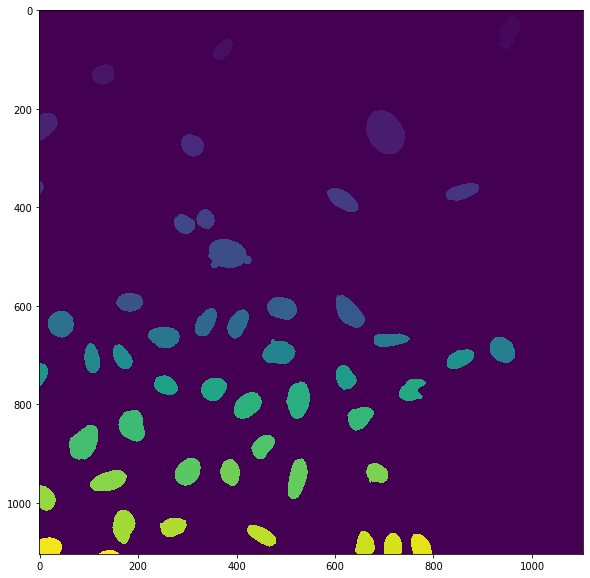

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170731090001_B05f12d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 51]. Convert image to uint8 prior to saving to suppress this warning.


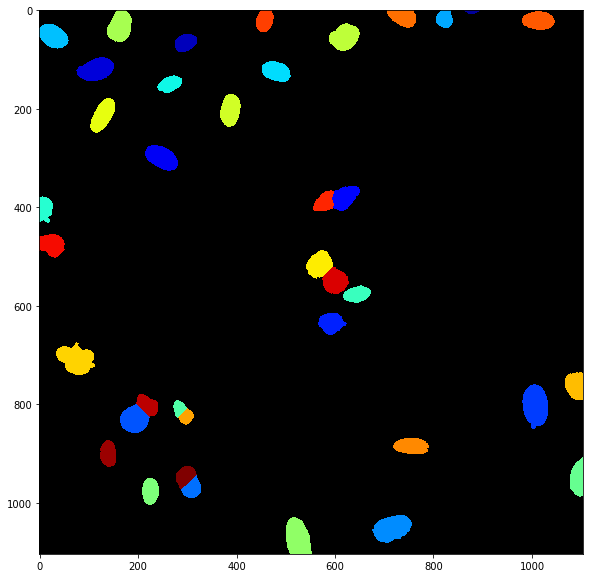

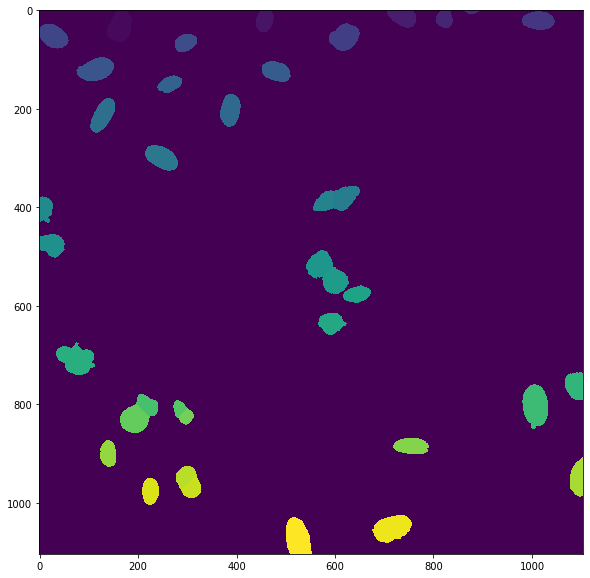

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702090001_A08f09d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 38]. Convert image to uint8 prior to saving to suppress this warning.


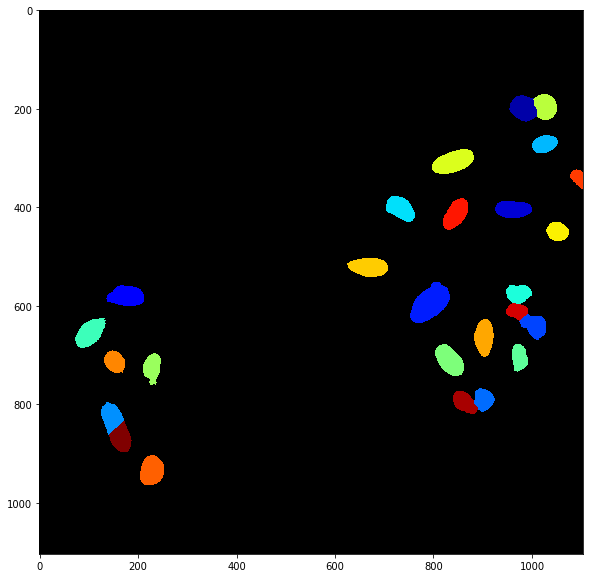

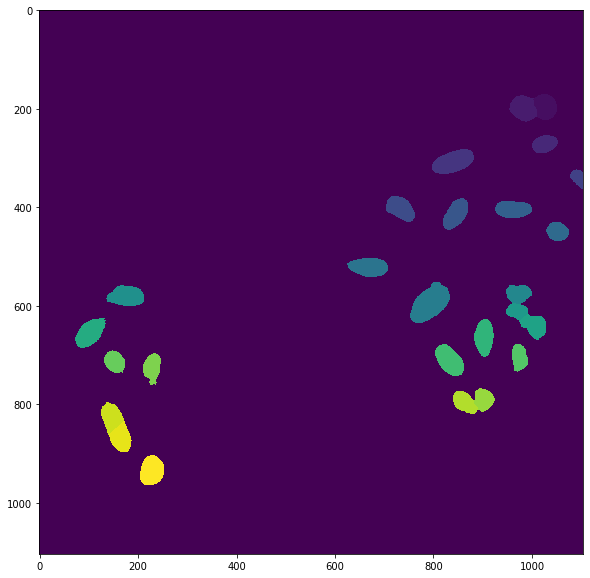

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702090001_A20f02d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 26]. Convert image to uint8 prior to saving to suppress this warning.


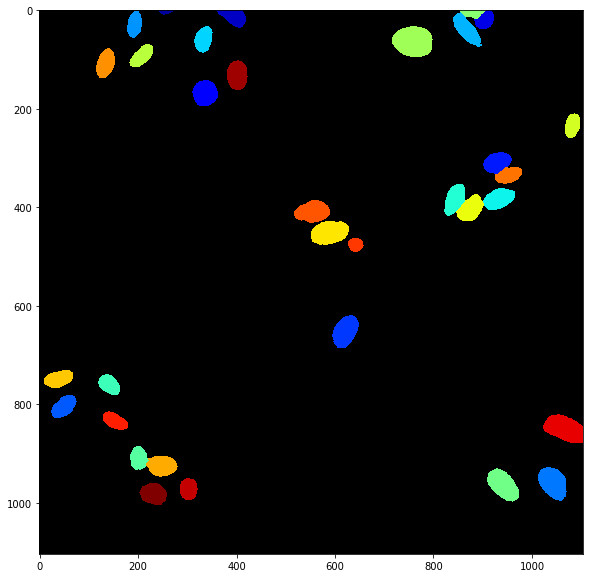

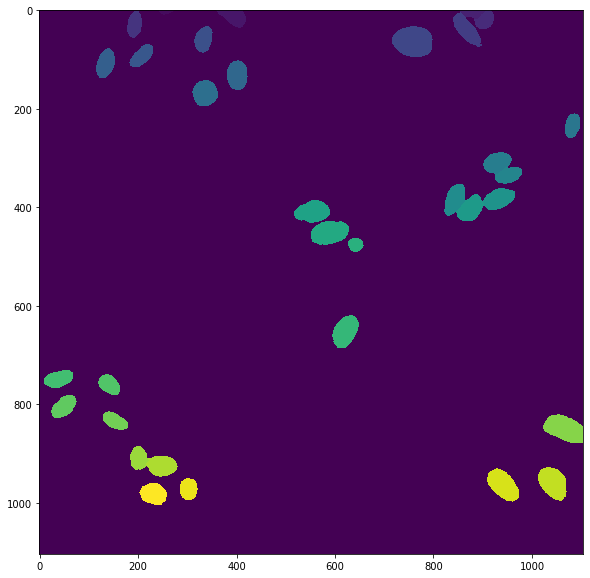

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702000001_B23f07d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 33]. Convert image to uint8 prior to saving to suppress this warning.


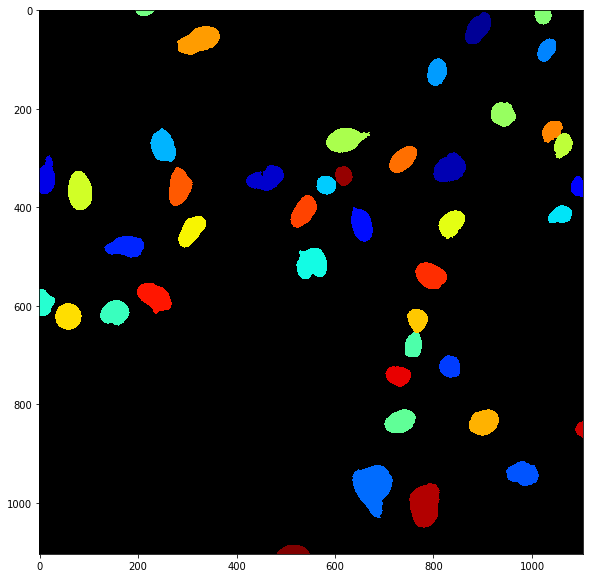

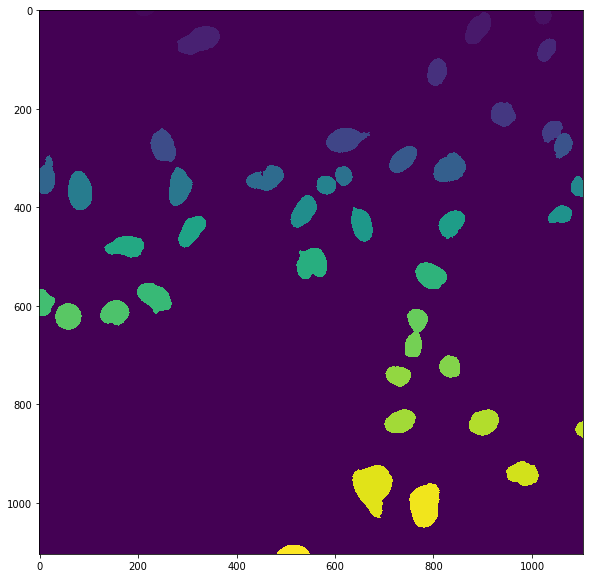

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170731090001_A01f04d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.


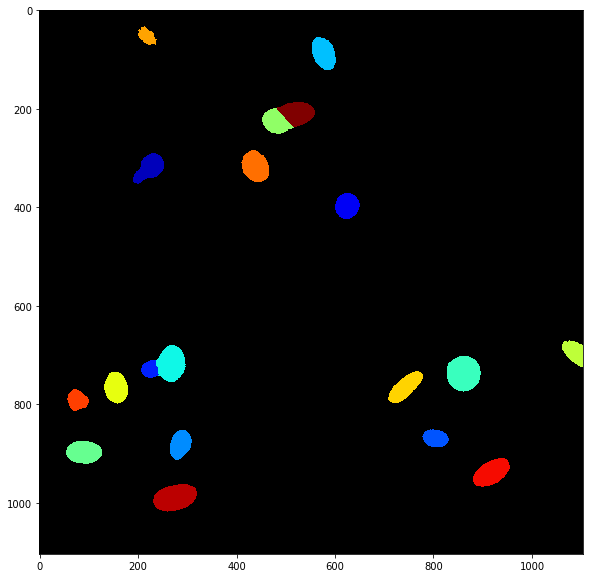

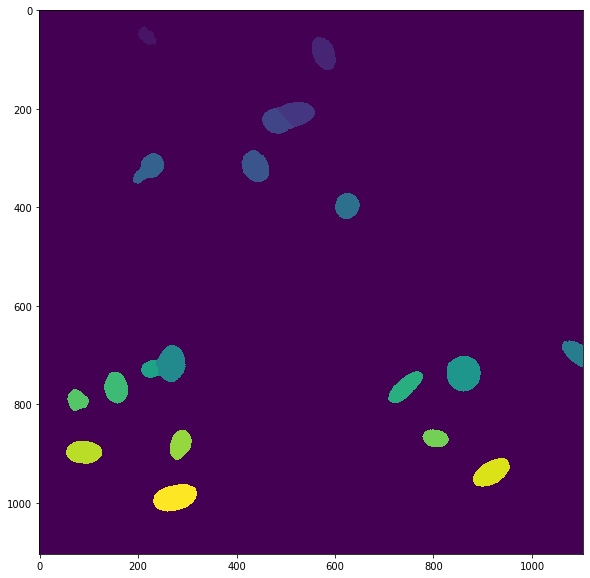

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702090001_P01f02d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 19]. Convert image to uint8 prior to saving to suppress this warning.


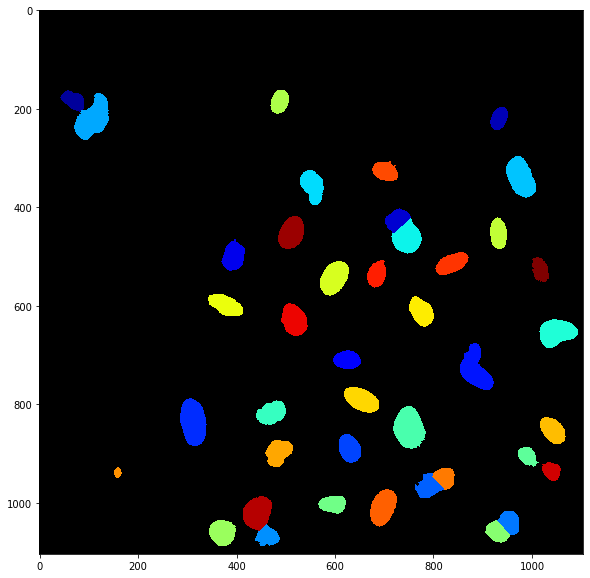

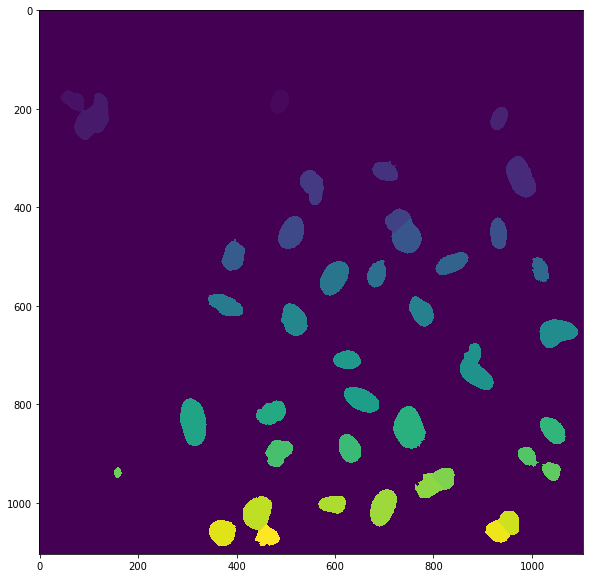

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702090001_K22f14d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.


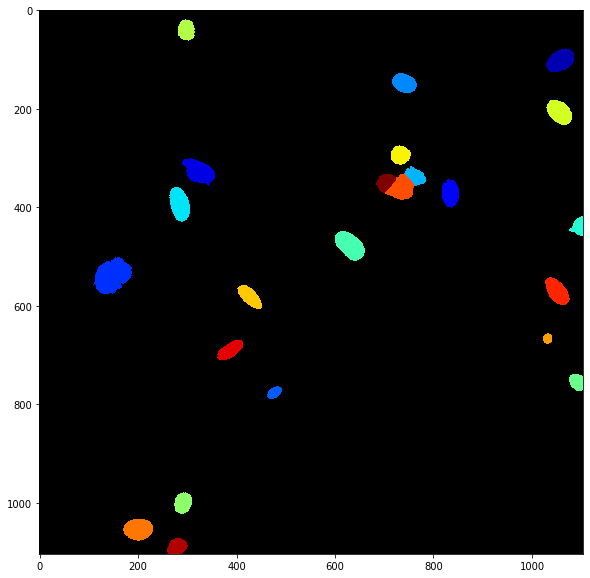

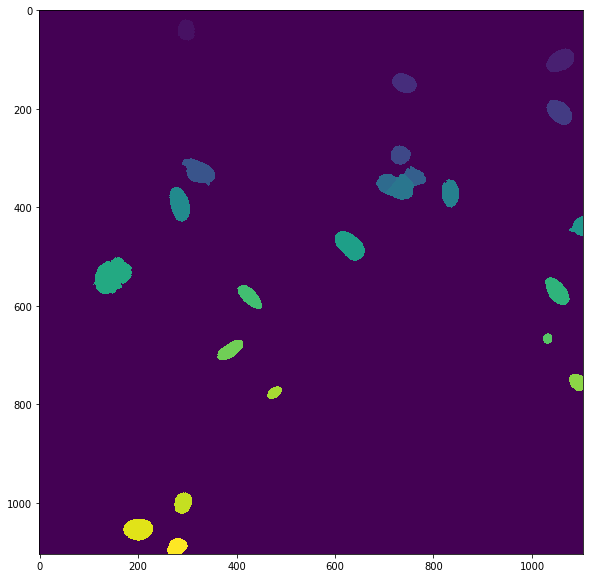

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: /home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/MFGTMPcx7_170702000001_F11f10d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 23]. Convert image to uint8 prior to saving to suppress this warning.


In [87]:
# Change to the image name

images_list =  os.listdir('/home/marmia/Mariam_Thesis/Evaluation_Data/Cellprofiler_predictions')

for image_name in images_list:
    # Change this variable to where the ground truth images (the true annotations) are stored.
    config_vars["raw_annotations_dir"] ='/home/marmia/Mariam_Thesis/Evaluation_Data/Ground_Truth/Nuclei/'
    # Change this to a new folder where you will store the labels created in this script
    config_vars["labels_out_dir"] = '/home/marmia/Mariam_Thesis/Evaluation_Data/Segmented_Images/'
    
    
    full_path_loading_img = '/home/marmia/Mariam_Thesis/Evaluation_Data/Cellprofiler_predictions/' + image_name

    full_path_saving_img = config_vars["labels_out_dir"] + image_name


    # Display prediction along with segmentation to visualize errors

    def show(ground_truth, prediction, threshold=0.5, image_name="N"):

        # Compute Intersection over Union
        IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

        # Create diff map
        diff = np.zeros(ground_truth.shape + (3,))
        A = ground_truth.copy()
        B = prediction.copy()
        A[A > 0] = 1
        B[B > 0] = 1
        D = A - B
        #diff[D > 0,:2] = 1
        #diff[D < 0,1:] = 1

        # Object-level errors
        C = IOU.copy()
        C[C>=threshold] = 1
        C[C<threshold] = 0
        missed = np.where(np.sum(C,axis=1) == 0)[0]
        extra = np.where(np.sum(C,axis=0) == 0)[0]

        for m in missed:
            diff[ground_truth == m+1, 0] = 1
        for e in extra:
            diff[prediction == e+1, 2] = 1

        # Display figures
        fig, ax = plt.subplots(1, 4, figsize=(18,6))
        ax[0].imshow(ground_truth)
        ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
        ax[1].imshow(diff)
        ax[1].set_title("Segmentation errors:"+str(len(missed)))
        ax[2].imshow(prediction)
        ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
        ax[3].imshow(IOU)
        ax[3].set_title(image_name)

    im = skimage.io.imread(full_path_loading_img)

    plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.show()

    im = rgb2lab(im)
    im2 = im[:,:,0]

    annot = skimage.morphology.label(im2)

    plt.figure(figsize=(10,10))
    plt.imshow(annot)
    plt.show()
    


    skimage.io.imsave(full_path_saving_img, annot)
    




    



    

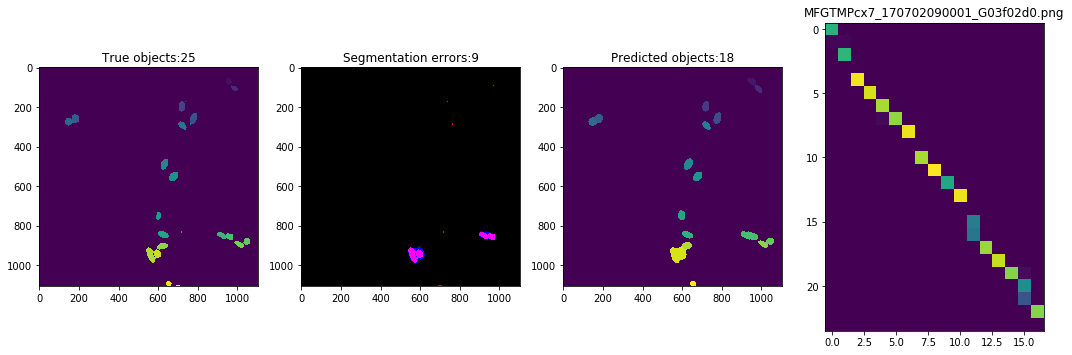

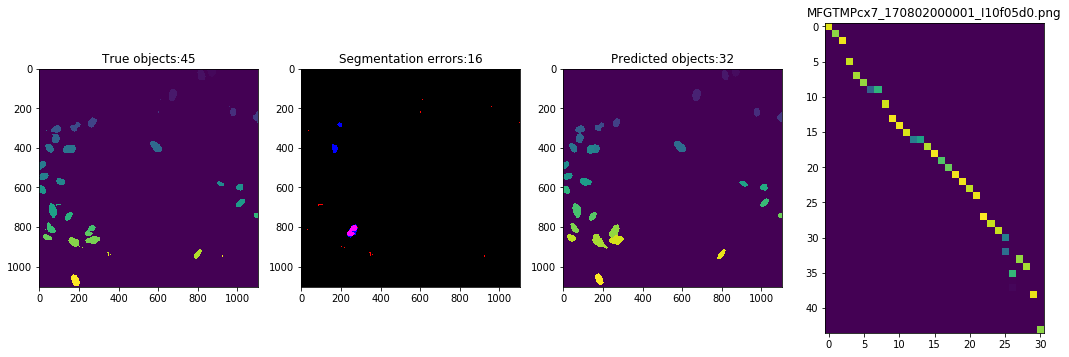

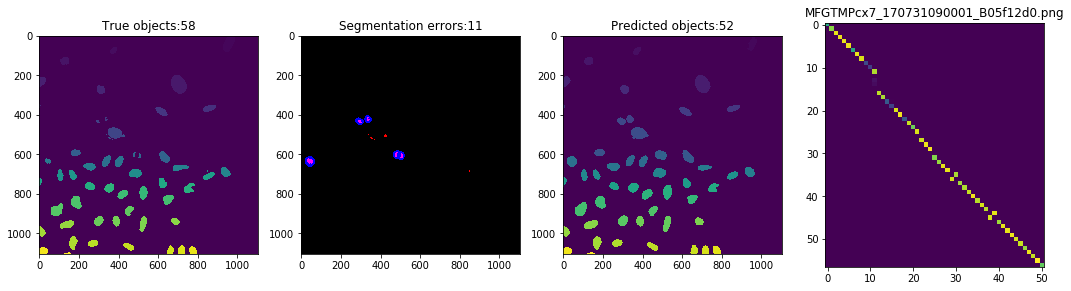

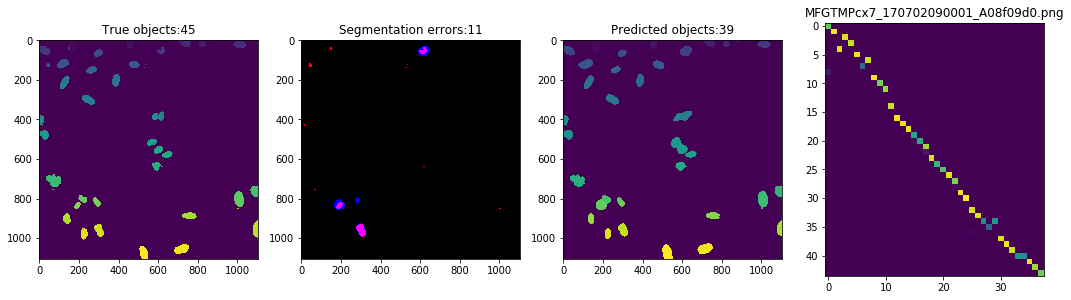

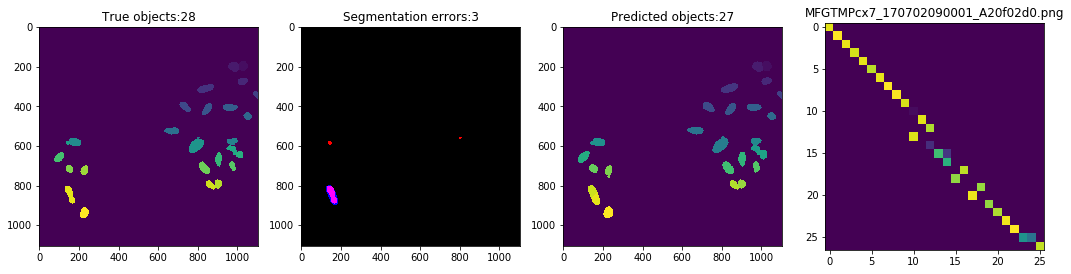

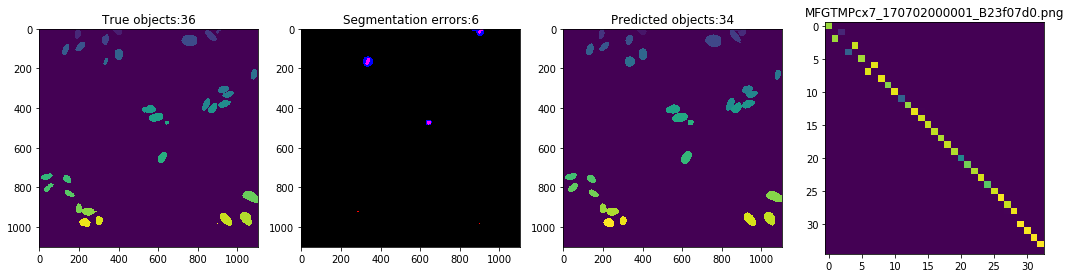

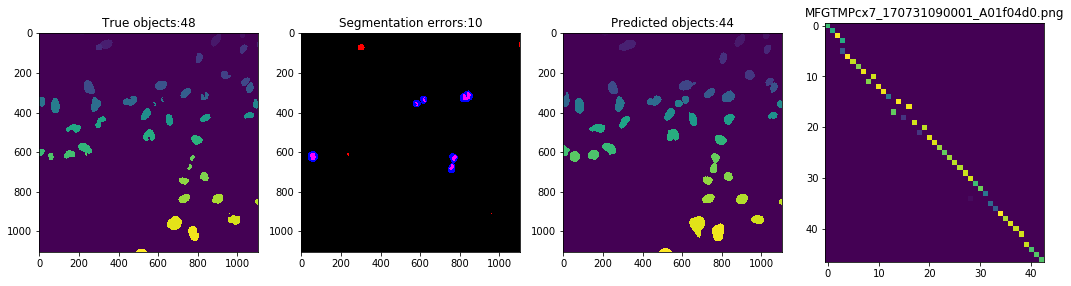

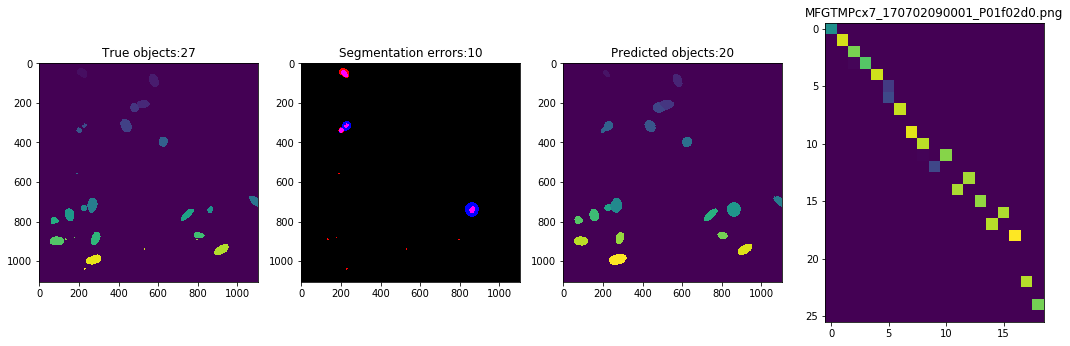

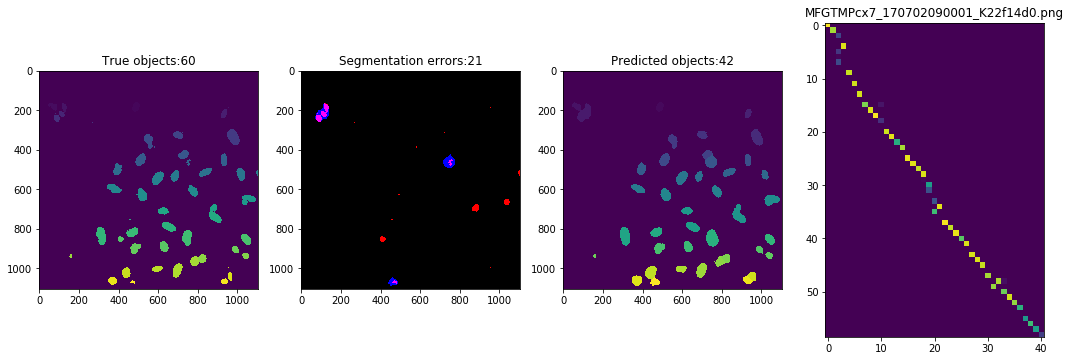

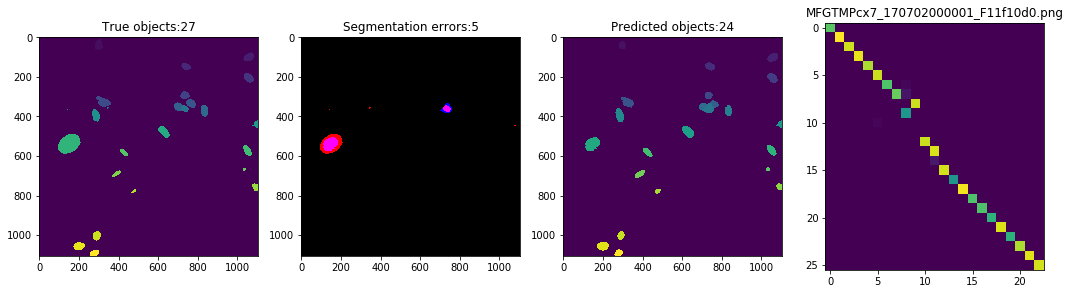

In [88]:


results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in images_list:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]

    ground_truth = skimage.morphology.label(ground_truth)

    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)

    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)


    #Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
#     struct = skimage.morphology.square(3)
#     ground_truth = skimage.morphology.dilation(ground_truth,struct)

    #Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )

    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name,
    )

    false_positives = utils.evaluation.get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name,
    )

    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    show(ground_truth, prediction, image_name=image_name)



,Image,Threshold,F1,Jaccard
0,MFGTMPcx7_170702000001_B23f07d0.png,0.725,0.667647,0.795177
8,MFGTMPcx7_170731090001_B05f12d0.png,0.725,0.666667,0.805570
3,MFGTMPcx7_170702090001_A20f02d0.png,0.725,0.664151,0.814493
2,MFGTMPcx7_170702090001_A08f09d0.png,0.725,0.585366,0.778678
7,MFGTMPcx7_170731090001_A01f04d0.png,0.725,0.551111,0.730883
1,MFGTMPcx7_170702000001_F11f10d0.png,0.725,0.538776,0.762365
9,MFGTMPcx7_170802000001_I10f05d0.png,0.725,0.538667,0.794060
5,MFGTMPcx7_170702090001_K22f14d0.png,0.725,0.526000,0.772317
6,MFGTMPcx7_170702090001_P01f02d0.png,0.725,0.524444,0.756361
4,MFGTMPcx7_170702090001_G03f02d0.png,0.725,0.473171,0.750437


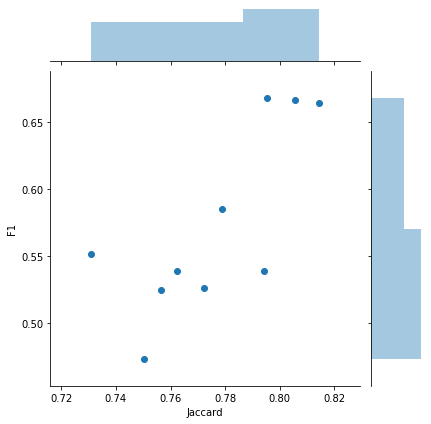

In [89]:

# Display accuracy results


average_performance = results.groupby("Threshold").mean().reset_index()
R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)


,Threshold,F1,Jaccard
0,0.50,0.804418,0.776034
1,0.55,0.793312,0.776034
2,0.60,0.756593,0.776034
3,0.65,0.733725,0.776034
4,0.70,0.701626,0.776034
5,0.75,0.667742,0.776034
6,0.80,0.587783,0.776034
7,0.85,0.443335,0.776034
8,0.90,0.234063,0.776034
9,0.95,0.013402,0.776034


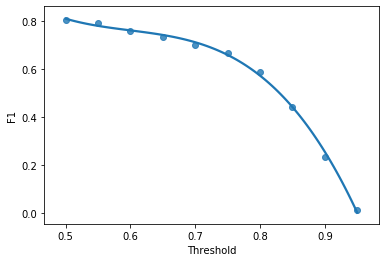

In [90]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [91]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.5735998986590163
Jaccard index: 0.7760340260509613


In [92]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      54
Small nuclei     53
Normal nuclei    20
Large nuclei     11
Name: False_Negative, dtype: int64

In [93]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei       NaN
Small nuclei     15.0
Normal nuclei    32.0
Large nuclei     24.0
Name: False_Positive, dtype: float64
FDR Tiny: nan
FDR Small: 0.0466
FDR Normal: 0.0994
FDR Large: 0.0745


In [94]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 6
Merges: 10


In [95]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 71


In [96]:
thresh = 0.7


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 71
True positives: 251
Total objects: 322
False discovery rate: 0.2204968944099379
